In [12]:
from setup import *
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import sys

E0, S0,  all_components = load_models(Egal_reuptake=False)
alpha_table = pd.read_csv('./Data/alpha_table_m2.csv', index_col=0)

# Alter Sij and check flux response in pfba
Analyzing limiting/ reduced cost?

In [13]:
import importlib
import setup
importlib.reload(setup)
from cobra import flux_analysis
from setup import get_BM_df
# with E0, S0:
#     current_gene = 'dapF'
#     alter_Sij(E0, alpha_table.loc[current_gene, 'E0'], current_gene)
#     print(E0.optimize())
    
#     solution = flux_analysis.pfba(E0)
#     print(solution.objective_value)

## Do calculation of drug combination effect

In [14]:
def loglinear(x, a, b, x_start, scale):
    return a*np.exp(b*(x-x_start)/scale)

def loglinear(x, a, b):
    return a*np.exp(b*(x))


# def loglinear(x, b):
#     return 1e-8*np.exp(b*(x))
def truncate_max_biomass(col_str, Biomass_df):
    fit_col = Biomass_df[col_str].dropna()
    cycles_to_fit = fit_col<fit_col.iloc[-1]*.9
    if any(cycles_to_fit.values) == False:
        return None
    
    truncate_col = fit_col.loc[cycles_to_fit]
    # min_tr, max_tr = fit_col[::-1].idxmin(), fit_col.idxmax()
    # truncate_col = fit_col[min_tr :max_tr] # wrong, should consider all for fitting, keep the lag
    # truncate_col = fit_col[:max_tr]
    return truncate_col 

def get_growth_info(col_str, Biomass_df, fit=False, plot_fitted=False, plot_og=False):
    def get_fitted_curve(x, *popt):
        y_fit = loglinear(x, *popt)
        return y_fit
    
    def plot_curves(plot_fitted, plot_og=True, **kwargs):
        if plot_og:
            plt.plot(x, y, label='Original Curve', **kwargs)
        if plot_fitted:        
            y_fit = get_fitted_curve(x,*popt)
            plt.plot(x, y_fit, label='Fitted Curve', **kwargs)
        
    fit_col = truncate_max_biomass(col_str, Biomass_df)
    # Biomass_df[col_str].dropna()
    
    if fit_col is None:
        return [0,0], 0, 0, 0 # popt
    x = fit_col.index
    y= fit_col
    # popt, pcov = curve_fit(loglinear, x, y, p0=[1e-8, .05,0, 2]) # [B,A] -- log(y) = A+Bx
    popt, pcov = curve_fit(loglinear, x, y, p0=[1e-8, .05]) # [B,A] -- log(y) = A+Bx
    # popt0, pcov0 = np.polyfit(x, np.log(y), 1) # [B,A] -- log(y) = A+Bx
    np_gr, est_initial_pop = np.polyfit(x, np.log(y), 1) # [B,A] -- log(y) = A+Bx
    
    # popt, pcov = curve_fit(loglinear, x, y, p0=[ .1]) # [B,A] -- log(y) = A+Bx

    plot_curves(plot_fitted, plot_og)

    return popt, pcov, np_gr, est_initial_pop
    # return popt, pcov


def plot_filtered_Biomass(g_str, culture, Biomass_df):
    Biomass_df.filter(regex=f'_{g_str}_{culture}').plot()

In [28]:
def get_Biomass_df_from_file(Biomass_df=None, method_suffix=None, checker_path=None):
    if method_suffix:
        SG_biomass = pd.read_csv(f'./Data/BM_SG_{method_suffix}.csv', index_col=0)
        # if BM_DG_m1.csv exists
        DG_biomass = pd.read_csv(f'./Data/BM_DG_{method_suffix}.csv', index_col=0) if os.path.isfile(f'./Data/BM_DG_{method_suffix}.csv') else pd.DataFrame()
        return pd.concat([SG_biomass, DG_biomass], axis=1)
    if checker_path:
        Biomass_df = pd.read_csv(checker_path, index_col=0)
    return Biomass_df

file_path = './Data/checkerboard_run4.csv'
Biomass_df = get_Biomass_df_from_file(checker_path=file_path)

In [34]:
from collections import defaultdict

# TODO: write into dataclaass
def initialize_growth_rate_dict(method):
    return {method: defaultdict(lambda: defaultdict(dict))}

def get_Biomass_df_from_file(Biomass_df=None, method_suffix=None, checker_path=None):
    if method_suffix:
        SG_biomass = pd.read_csv(f'./Data/BM_SG_{method_suffix}.csv', index_col=0)
        # if BM_DG_m1.csv exists
        DG_biomass = pd.read_csv(f'./Data/BM_DG_{method_suffix}.csv', index_col=0) if os.path.isfile(f'./Data/BM_DG_{method_suffix}.csv') else pd.DataFrame()
        return pd.concat([SG_biomass, DG_biomass], axis=1)
    if checker_path:
        Biomass_df = pd.read_csv(checker_path, index_col=0)
    return Biomass_df
        
def fill_growth_info(Biomass_df=None, method_suffix=None, growth_info=defaultdict(lambda: defaultdict(dict)), n_genes=None):
    def Bliss_Mult(x, y):
        return x * y

    def fill_growth_rate_dict(growth_info, col):
        Species, gcomb, culture, *lv_pairs = col.split('_')
        gcomb = '_'.join([gcomb, *lv_pairs])
        sp_cul = '_'.join([Species, culture])

        if sp_cul in growth_info[gcomb]:
            return growth_info[gcomb][sp_cul]

        inner_dict = growth_info[gcomb][sp_cul] # modify this dict below
        inner_dict['popt'], inner_dict['pcov'], inner_dict['popt_np'], inner_dict['pcov_np'] = get_growth_info(col, Biomass_df=Biomass_df)
        # inner_dict['growth_rate'] = inner_dict['popt'][1]
        # inner_dict['growth_rate_err'] = inner_dict['pcov'][1,1]
        # inner_dict['pred_initial_pop'] = inner_dict['popt'][0]

        inner_dict['growth_rate'] = inner_dict['popt'][0]
        inner_dict['growth_rate_np'] = inner_dict['popt_np']
        
        if len(gcomb.split('.')) == 1:
            inner_dict['XG'] = 'SG'
        elif len(gcomb.split('.')) == 2: 
            g1, g2 = gcomb.split('.')
            inner_dict['XG'] = 'DG'

# Re uncomment
            for current_gene, nth in zip([g1, g2], ['first_gene', 'second_gene']):
                inner_dict[nth] = current_gene
                if sp_cul in growth_info[gcomb]:
                    print(sp_cul+f'{nth}_gene', inner_dict.keys())
                    print(method_suffix,current_gene,sp_cul)
                    print(growth_info.keys())
                    if current_gene not in growth_info:
                        sys.exit('Missing current gene biomass column, add back repeated columns with m1')
                    inner_dict[sp_cul+f'{nth}_gene'] = growth_info[current_gene][sp_cul]['growth_rate']
                
                
                # else: 
                #     pass
                    # fill_growth_rate_dict('_'.join([Species, current_gene, culture]))
                
            # inner_dict['Predicted_drug_combination_effect'+sp_cul] = Bliss_Mult(
            #     inner_dict[sp_cul+'first_gene'], inner_dict[sp_cul+'second_gene'])
            # inner_dict['po_diff'+sp_cul] = inner_dict['Predicted_drug_combination_effect'+sp_cul] - inner_dict['growth_rate']
            # inner_dict['po_diff'+sp_cul+'normalized'] = inner_dict['po_diff'+sp_cul]/inner_dict['growth_rate']
        return growth_info
    
    Biomass_df = get_Biomass_df_from_file(Biomass_df=Biomass_df, method_suffix=method_suffix)

    if n_genes is None:
        n_genes = len(Biomass_df.columns)
    for col in Biomass_df.columns[:n_genes]: 
        print(col) 
        fill_growth_rate_dict(growth_info, col)
    return growth_info    
    
def classify_XG(s, checker_option=False):
    splitted = s.split('.')
    is_checkerboard_XG = False
    is_SG = False
    if len(splitted) <=2:
        if len(splitted) == 1:
            is_SG = True
    else:
        is_checkerboard_XG = True
        if '0' in s:
            is_SG = True
    XG = 'SG' if is_SG else 'DG'
    return XG if not checker_option else (XG, is_checkerboard_XG) 

    
def retrive_growth_rate_value(growth_info):  
    def reorder_rows(df):
        df['XG'] = [classify_XG(s) for s in df.index]        
        df['XG'] = pd.Categorical(df['XG'], categories=['DG', 'SG'])
        return df.sort_values(['XG', 'E0_coculture'], ascending=False)
    
    def get_growth_df(key):
        growth_df = {current_gene: 
                {sp_cul:
                d2[key] for sp_cul, d2 in d1.items()}
                    for current_gene, d1 in growth_info.items()} 
        return growth_df
    
    def get_growth_df_from_dict(key):
        df = pd.DataFrame.from_dict(get_growth_df(key), orient='index')
        df = reorder_rows(df)
        df.index.name = 'Gene_inhibition'
        
        return df
    
    result = {key: get_growth_df_from_dict(key) for key in ['growth_rate', 'growth_rate_np']}

    return result 
 
# growth_info = defaultdict(dict)
# gr_only = {}
# for method_suffix in ['m1', 'm2']:
# # for method_suffix in ['m1']:
# # for method_suffix in [ 'm3']:
#     growth_info.update(initialize_growth_rate_dict(method_suffix))
#     Biomass_df = get_Biomass_df_from_file(method_suffix=method_suffix)
#     growth_info['Biomass'][method_suffix] = Biomass_df
#     growth_info[method_suffix] = fill_growth_info(method_suffix=method_suffix, growth_info=growth_info[method_suffix], n_genes=None)

#     gr_only[method_suffix] = retrive_growth_rate_value(growth_info[method_suffix])

#     for key in ['growth_rate', 'growth_rate_np']:
#         filename_prefix = key.replace('growth_rate', 'gr_SG')
#         print(filename_prefix)
#         gr_only[method_suffix][key].to_csv(f'./Data/{filename_prefix}_{method_suffix}.csv')

#         # with alphatable info
#         # alpha_table = pd.read_csv(f'./Data/_alpha_table_{method_suffix}.csv', index_col=0) # include the underscore alp here
#         alpha_table = pd.read_csv(f'./Data/alpha_table_{method_suffix}.csv', index_col=0)
#         pd.concat([gr_only[method_suffix][key], alpha_table], axis=1).to_csv(f'./Data/_{filename_prefix}_{method_suffix}.csv')


In [38]:
alpha_table

,E0,S0,lv_pairs,ICX
Gene_inhibition,,,,
folP,1.0,1.00,"(0, 0)","[1, 1]"
folA,1.0,1.00,"(0, 0)","[1, 1]"
folP,1.0,1.00,"(0, 1)","[1, 1]"
folA,1.0,1.95,"(0, 1)","[1, 0.95]"
folP,1.0,1.00,"(0, 2)","[1, 1]"
...,...,...,...,...
folA,6.6,8.40,"(5, 3)","[0.9, 0.7]"
folP,6758.4,94660.80,"(5, 4)","[0.45, 0]"
folA,52.8,29.40,"(5, 4)","[0.5, 0.376]"


In [40]:
from growth_summary import get_desired_cycle
desired_cycle = get_desired_cycle(Biomass_df)

In [41]:
desired_cycle

,c_max_gr,start,end,bool_growing,cycle_max_gr,growth_phase,growth_phase_length,end_cycle,Species,Gene_inhibition,culture,alpha_lv_pairs
folP.folA_0.0,115,102,120,0.0,115,"[102, 120]",18.0,1250,E0,folP.folA_0.0,coculture,0.0
folP.folA_0.0,115,102,119,0.0,115,"[102, 119]",17.0,1250,S0,folP.folA_0.0,coculture,0.0
folP.folA_0.0,23,20,26,0.0,25,"[20, 26]",6.0,1250,E0,folP.folA_0.0,monoculture,0.0
folP.folA_0.0,107,86,115,0.0,105,"[86, 115]",29.0,1250,S0,folP.folA_0.0,monoculture,0.0
folP.folA_0.1,124,110,130,0.0,125,"[110, 130]",20.0,1250,E0,folP.folA_0.1,coculture,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
folP.folA_5.4,1245,126,1126,1.0,1245,"[126, 1126]",10000.0,1250,S0,folP.folA_5.4,monoculture,5.4
folP.folA_5.5,1245,125,1130,1.0,1245,"[125, 1130]",10000.0,1250,E0,folP.folA_5.5,coculture,5.5
folP.folA_5.5,1243,124,1129,1.0,1245,"[124, 1129]",10000.0,1250,S0,folP.folA_5.5,coculture,5.5
folP.folA_5.5,1245,127,1127,1.0,1245,"[127, 1127]",10000.0,1250,E0,folP.folA_5.5,monoculture,5.5


In [37]:
gr_only['checkerboard']['growth_rate_np']

,E0_coculture,S0_coculture,E0_monoculture,S0_monoculture,XG
Gene_inhibition,,,,,
folP.folA_0.0,0.116352,0.109452,0.551846,0.074824,SG
folP.folA_1.0,0.108197,0.101858,0.529166,0.071605,SG
folP.folA_0.1,0.107223,0.100826,0.551846,0.071386,SG
folP.folA_2.0,0.100096,0.094164,0.498291,0.068345,SG
folP.folA_0.2,0.099428,0.093540,0.532867,0.067936,SG
folP.folA_3.0,0.077569,0.072827,0.488933,0.059421,SG
folP.folA_0.3,0.068517,0.064160,0.513495,0.054358,SG
folP.folA_0.4,0.030533,0.028179,0.284452,0.030587,SG
folP.folA_4.0,0.016971,0.015561,0.338724,0.021446,SG


In [35]:
Biomass_df = get_Biomass_df_from_file(checker_path=file_path)
method_suffix = 'checkerboard'
growth_info = defaultdict(dict)
gr_only = {}
growth_info.update(initialize_growth_rate_dict(method_suffix))

growth_info['Biomass'][method_suffix] = Biomass_df
growth_info[method_suffix] = fill_growth_info(Biomass_df=Biomass_df, growth_info=growth_info[method_suffix], n_genes=None)

gr_only[method_suffix] = retrive_growth_rate_value(growth_info[method_suffix])

for key in ['growth_rate', 'growth_rate_np']:
    filename_prefix = key.replace('growth_rate', 'gr_SG')
    print(filename_prefix)
    gr_only[method_suffix][key].to_csv(f'./Data/{filename_prefix}_{method_suffix}.csv')

    alpha_table = pd.read_csv("./Data/checkerboard_alpha_table.csv", index_col=0)
    # pd.concat([gr_only[method_suffix][key], alpha_table], axis=1).to_csv(f'./Data/_{filename_prefix}_{method_suffix}.csv')


E0_folP.folA_coculture_0.0
S0_folP.folA_coculture_0.0
E0_folP.folA_monoculture_0.0
S0_folP.folA_monoculture_0.0
E0_folP.folA_coculture_0.1
S0_folP.folA_coculture_0.1
E0_folP.folA_monoculture_0.1
S0_folP.folA_monoculture_0.1
E0_folP.folA_coculture_0.2
S0_folP.folA_coculture_0.2
E0_folP.folA_monoculture_0.2
S0_folP.folA_monoculture_0.2
E0_folP.folA_coculture_0.3
S0_folP.folA_coculture_0.3
E0_folP.folA_monoculture_0.3
S0_folP.folA_monoculture_0.3
E0_folP.folA_coculture_0.4
S0_folP.folA_coculture_0.4
E0_folP.folA_monoculture_0.4
S0_folP.folA_monoculture_0.4
E0_folP.folA_coculture_0.5
S0_folP.folA_coculture_0.5
E0_folP.folA_monoculture_0.5
S0_folP.folA_monoculture_0.5
E0_folP.folA_coculture_1.0
S0_folP.folA_coculture_1.0
E0_folP.folA_monoculture_1.0
S0_folP.folA_monoculture_1.0
E0_folP.folA_coculture_1.1
S0_folP.folA_coculture_1.1
E0_folP.folA_monoculture_1.1
S0_folP.folA_monoculture_1.1
E0_folP.folA_coculture_1.2
S0_folP.folA_coculture_1.2
E0_folP.folA_monoculture_1.2
S0_folP.folA_monocult

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [47]:
gr_only[method_suffix][key].index

Index(['folP.folA_0.0', 'folP.folA_1.0', 'folP.folA_0.1', 'folP.folA_2.0',
       'folP.folA_0.2', 'folP.folA_3.0', 'folP.folA_0.3', 'folP.folA_0.4',
       'folP.folA_4.0', 'folP.folA_5.0', 'folP.folA_0.5', 'folP.folA_3.5',
       'folP.folA_2.5', 'folP.folA_3.3', 'folP.folA_2.3', 'folP.folA_3.2',
       'folP.folA_2.2', 'folP.folA_1.3', 'folP.folA_1.2', 'folP.folA_1.1',
       'folP.folA_2.1', 'folP.folA_3.1', 'folP.folA_4.2', 'folP.folA_4.1',
       'folP.folA_1.5', 'folP.folA_3.4', 'folP.folA_4.5', 'folP.folA_5.1',
       'folP.folA_5.2', 'folP.folA_5.3', 'folP.folA_5.4', 'folP.folA_5.5',
       'folP.folA_4.4', 'folP.folA_4.3', 'folP.folA_1.4', 'folP.folA_2.4'],
      dtype='object', name='Gene_inhibition')

In [60]:
s='dapF.malT.0'
s='dapF.d_0.3'
classify_XG(s, checker_option=False)


'SG'

In [48]:
normal_index = ['Normal', 'folP.folA_0.0']
gr_only[method_suffix][key].query('index in @normal_index')

,E0_coculture,S0_coculture,E0_monoculture,S0_monoculture,XG
Gene_inhibition,,,,,
folP.folA_0.0,1.948977e-09,6.792743e-10,9.983507e-07,1.000000e-08,SG


In [69]:
def generate_p_o_df(method_n, normalize=False):
    def reorder_columns(df):
        column_order = ['E0_coculture', 'S0_coculture',
       'Predicted_additive_effect_E0_coculture',
       'Predicted_additive_effect_S0_coculture', 'E0_monoculture',
       'S0_monoculture', 'Predicted_additive_effect_E0_monoculture',
       'Predicted_additive_effect_S0_monoculture', 'First_gene',
       'E0_monoculture_First_gene', 'S0_monoculture_First_gene', 'Second_gene',
       'E0_coculture_Second_gene', 'S0_coculture_Second_gene',
       'E0_monoculture_Second_gene', 'S0_monoculture_Second_gene',
       'po_diff_E0_coculture', 'po_diff_S0_coculture',
       'po_diff_E0_monoculture', 'po_diff_S0_monoculture',
       'po_diff_E0_coculture_rescaled_by_predicted', 'po_diff_S0_coculture_rescaled_by_predicted',
       'po_diff_E0_monoculture_rescaled_by_predicted', 'po_diff_S0_monoculture_rescaled_by_predicted']
        
        return df.reindex(columns=[col for col in column_order if col in df.columns])

    def Bliss_Mult(x, y):
        return x * y
    
    def get_spilitted_gene(s='folP.folA_1.1'):
        _, is_checker_XG = classify_XG(s, checker_option=True)
        if not is_checker_XG:
            return s.split('.')
        First_gene, Second_gene = s,s
        First_gene = First_gene[:-1] + '0'
        Second_gene = Second_gene[:-3] + '0' + Second_gene[-2:]
        return First_gene, Second_gene

    def add_columns(gene_row, SG_df, normalize=False):
        gene_row = gene_row.copy()
        
        cols = gene_row.drop('XG').index
        # add new columns First gene, second gene, predictive additive effect, p-o difference
        if gene_row.name == 'Normal':
            return gene_row
        
        # make compatible checker SG .x x.
        temp_splitted_gene = get_spilitted_gene(gene_row.name)

        for sp_cult in cols:
            observed_growth_rate = gene_row[sp_cult]
            for current_gene, nth in zip(temp_splitted_gene, ['First_gene', 'Second_gene']):
                gene_row[nth] = current_gene
                # print(current_gene)
                gene_row[sp_cult+f'_{nth}'] = SG_df.loc[current_gene, sp_cult]
                
            if normalize:
                gene_row['Predicted_additive_effect_'+sp_cult] =  Bliss_Mult(*gene_row.filter(regex=f'{sp_cult}_'))
                gene_row['po_diff_'+sp_cult] = gene_row['Predicted_additive_effect_'+sp_cult] - observed_growth_rate
                gene_row['po_diff_'+sp_cult+'_scaled_by_predicted'] = gene_row['po_diff_'+sp_cult]/(gene_row['Predicted_additive_effect_'+sp_cult]+1e-5)
        return gene_row
    
    def save_files(df, normalize):
        SG_df = df.query('XG == "SG"')
        normal_index = ['Normal', 'folP.folA_0.0']
        DG_df = df.query('index in @normal_index |XG == "DG"')

        df = DG_df.apply(lambda x: add_columns(x, SG_df=SG_df.copy(), normalize=normalize), axis=1)
        file_suffix = '_normalized' if normalize else ''
        df.index.name = 'Gene_inhibition'
        df = reorder_columns(df)
        df.to_csv(f'./Data/gr_DG_{method_n}{file_suffix}.csv')
        return df
    
    type_growth_rate = 'growth_rate_np'
    df = gr_only[method_n][type_growth_rate].copy()

    if 'Normal' in df:
        Normal_growth_rate = df.loc['Normal','E0_coculture':'S0_monoculture']
    else:
        Normal_growth_rate = df.loc['folP.folA_0.0', 'E0_coculture':'S0_monoculture']
    df_norm = df.loc[:,'E0_coculture':'S0_monoculture'].div(Normal_growth_rate, axis=1)
    df_norm['XG'] = df['XG']
    
    df = save_files(df, normalize=False)
    df_norm = save_files(df_norm, normalize=True)
    return df_norm if normalize else df

# p3 = generate_p_o_df('m3', normalize=True)
# for method_n in ['m1', 'm2',]:
# # for method_n in ['m1', 'm2', 'm3']:
#     gr_only[method_n]['normalized'] = generate_p_o_df(method_n, normalize=True) 
generate_p_o_df('checkerboard')

,E0_coculture,S0_coculture,E0_monoculture,S0_monoculture,First_gene,E0_monoculture_First_gene,S0_monoculture_First_gene,Second_gene,E0_coculture_Second_gene,S0_coculture_Second_gene,E0_monoculture_Second_gene,S0_monoculture_Second_gene
Gene_inhibition,,,,,,,,,,,,
folP.folA_0.0,0.116352,0.109452,0.551846,0.074824,folP.folA_0.0,0.551846,0.074824,folP.folA_0.0,0.116352,0.109452,0.551846,0.074824
folP.folA_1.1,0.089724,0.084346,0.529166,0.064578,folP.folA_1.0,0.529166,0.071605,folP.folA_0.1,0.107223,0.100826,0.551846,0.071386
folP.folA_2.1,0.075244,0.070540,0.498291,0.058407,folP.folA_2.0,0.498291,0.068345,folP.folA_0.1,0.107223,0.100826,0.551846,0.071386
folP.folA_1.2,0.068350,0.069373,0.068358,0.058250,folP.folA_1.0,0.529166,0.071605,folP.folA_0.2,0.099428,0.093540,0.532867,0.067936
folP.folA_3.1,0.047860,0.044729,0.488933,0.044452,folP.folA_3.0,0.488933,0.059421,folP.folA_0.1,0.107223,0.100826,0.551846,0.071386
folP.folA_1.3,0.033875,0.034262,0.033848,0.038732,folP.folA_1.0,0.529166,0.071605,folP.folA_0.3,0.068517,0.064160,0.513495,0.054358
folP.folA_2.2,0.032423,0.032956,0.032386,0.050321,folP.folA_2.0,0.498291,0.068345,folP.folA_0.2,0.099428,0.093540,0.532867,0.067936
folP.folA_3.2,0.024643,0.025016,0.024615,0.034771,folP.folA_3.0,0.488933,0.059421,folP.folA_0.2,0.099428,0.093540,0.532867,0.067936
folP.folA_2.3,0.015555,0.015859,0.015530,0.029394,folP.folA_2.0,0.498291,0.068345,folP.folA_0.3,0.068517,0.064160,0.513495,0.054358


# plots to checking goodness of fit

In [17]:
# Try dadX only, E should larger than or eq to S
dadX_df = Biomass_df.filter(regex='_dadX_')

growth_rate_d = initialize_growth_rate_dict()
growth_rate_d = get_growth_rate('E0_dadX_coculture', dadX_df, plot_fitted=True, plot_og=True)

TypeError: initialize_growth_rate_dict() missing 1 required positional argument: 'method'

# Compare between method


In [ ]:
gr_m1 = pd.read_csv('./Data/_gr_SG_np_m1.csv', index_col=0)
gr_m2 = pd.read_csv('./Data/_gr_SG_np_m2.csv', index_col=0)

In [ ]:
# log_step =
globals().get('E',1)
# print(a)


1

In [ ]:
cols = ['E0_coculture', 'E0_monoculture', 'E0_alpha']
cols = ['E0_coculture', 'E0_monoculture', 'E0']
# cols = [ 'E0_monoculture', 'E0_alpha']
pd.set_option('display.max_rows', 150)

gr_m1[cols].merge(gr_m2[cols], left_index=True, right_index=True, suffixes=('_m1', '_m2')).round(3)

,E0_coculture_m1,E0_monoculture_m1,E0_m1,E0_coculture_m2,E0_monoculture_m2,E0_m2
Gene_inhibition,,,,,,
pykF,0.283,0.562,100000.000,0.283,0.562,100000.000
gltD,0.161,0.319,1.124,0.138,0.139,1.194
pgi,0.145,0.531,100000.000,0.145,0.531,100000.000
serA,0.142,0.551,100000.000,0.142,0.551,100000.000
serB,0.142,0.551,100000.000,0.142,0.551,100000.000
glyA,0.135,0.554,100000.000,0.135,0.554,100000.000
gdhA,0.127,0.533,100000.000,0.127,0.533,100000.000
purU,0.118,0.562,100000.000,0.118,0.562,100000.000
purN,0.118,0.560,100000.000,0.118,0.560,100000.000


In [ ]:
# plot mono diff

<Axes: xlabel='cycle'>

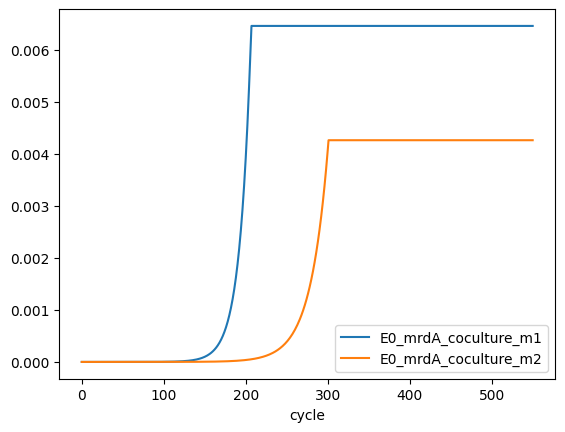

In [ ]:
# bm_m1 = pd.read_csv('./Data/BM_SG_m1.csv', index_col=0)
# bm_m2 = pd.read_csv('./Data/BM_SG_m2.csv', index_col=0)
gcol = 'E.*mrdA.*co'
bm_m1.filter(regex=gcol).merge(bm_m2.filter(regex=gcol), left_index=True, right_index=True, suffixes=('_m1', '_m2')).plot()